# Church Farm 2023 data 

Run in 24hr_env for now

- Looking at specific pathogens at Genus level (Puccinia, Blumeria, Fusarium, Zymoseptoria, Ustilago, Magnaporthe)
- See how the relative abundance changes over time
- If the pathogens are present consider looking at species level

Initial script was written just using 9 samples from the flush experiment https://docs.google.com/document/d/195KVG5wKhtiVNf4hXisKns8U0gYJ3icAd1u810GMKlc/edit#heading=h.mdjgzo7ffwni 

Before starting I get MARTi lineage data using taxonkit, script is within this directory ([Script](taxonkit_lineage_from_marti.sh)) https://docs.google.com/document/d/1s6LFdmZNQqBXO8JnumuIPyfSVSoHIF86bU2hCJQBiSw/edit

In [102]:
import pandas as pd
from dateutil.parser import parse
import seaborn as sns
import datetime as dt
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.pyplot as plt

## Reading in and prep the data 
- lineage data
- MARTi 
- metadata
- PHIbase taxonomic data (Have not generated for this sequencing run)

Data from the flush experiment - no longer looking at individually

In [ ]:
# marti_flush = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17.csv")
# marti_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17_taxaID_lineage.csv")
# marti_lineage = marti_lineage.drop(0) #removing the first row \
# marti_lineage['NCBI ID'] = marti_lineage['NCBI ID'].astype('int64')

Read in and clean taxonkit lineage data

In [62]:
marti_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/marti_assignments_lca_0.0_all_levels_2024-OCT-8_16-34-1_taxaID_lineage.csv")
marti_lineage = marti_lineage.drop(0) #removing the first row \
marti_lineage['NCBI ID'] = marti_lineage['NCBI ID'].astype('int64')


In [8]:
#Check no NCBI IDs are missing in the lineage data
# missing_taxaIDs = marti[~marti['NCBI ID'].isin(marti_lineage['NCBI ID'])]
# missing_taxaIDs # should be empty

Read in and clean MARTi Read counts - 
This has a column for the assigned (not labelled) and summed read count for all the barcode. I want to use the assigned counts, as with full lineage I can collapse to different taxonomic levels and sum as necessary. Contig stats and data are from the flush experiment

In [65]:
marti = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/marti_assignments_lca_0.0_all_levels_2024-OCT-8_16-34-1.tsv", sep='\t')

columns_to_keep = [col for col in marti.columns if 'Summed' not in col and 'identity' not in col]
marti_assi = marti[columns_to_keep]

# The string to be removed
string_to_remove = " (regular_cf_2023_lm) Read count"

# Modify all column headers to remove the specified string
marti_assi.columns = [col.replace(string_to_remove, '') for col in marti_assi.columns]

Reading and cleaning the metadata 
- convert date formats 

In [66]:
meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/CF_2023_metadata.csv")

meta[['DNA extracted?', 'WGA date', 'Initial bead clean up']] = meta[
    ['DNA extracted?', 'WGA date', 'Initial bead clean up']].apply(
        lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

#This is assuming where I don't know the date of collection it's on the 14th of the month as that's the middle

def parse_dates(x):
    try:
        # If the date is in 'mmm-yy' format, add '14-' to the start to make it 'dd-mmm-yy'
        if '-' in x and len(x) == 6:
            x = '14-' + x

        return parse(x, dayfirst=True)
    except:
        return pd.NaT

meta['Date collected'] = meta['Date collected'].apply(parse_dates)

Parsing the contig stats data
- Which has all the barcode info from the sequencing 
- I am only interested in barcode 1 - 39 for this experiment

In [64]:
contig_stats = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/combined_contig_stats.tsv", sep='\t')
contig_stats = contig_stats.replace(',', '', regex=True) #Don't need this as there aren't commas
contig_stats['Barcode'] = contig_stats['Barcode'].str.replace('barcode', '')
contig_stats.iloc[:] = contig_stats.iloc[:].astype(int)
contig_stats = contig_stats[contig_stats['Barcode'].astype(int) <= 39]

### Merging all the various datasets together
Working on this section of script, specifically contig stats

In [92]:
#Melt the data to long
marti_assi_long = marti_assi.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

#Add lineage data and merge on NCBI ID
marti_lin_merge = marti_assi_long.merge(marti_lineage, how='right')

# #Add metadata and merge on Sample which the same in metadata
marti_lin_meta_merge = marti_lin_merge.merge(meta, how='right')

#Use meta to add sample to contig stats using barcode 
contig_stats['Sample'] = contig_stats['Barcode'].map(meta.set_index('Barcode')['Sample'])

#then merge on Sample
marti_all_data = marti_lin_meta_merge.merge(contig_stats, how='right', on='Sample')

#Create column for relative abundance
marti_all_data["rel_abundance"] = (marti_all_data["read count"] / marti_all_data["NumContigs"]) * 100

#create column for HPM
marti_all_data["HPM"] = (marti_all_data["read count"] / marti_all_data["NumContigs"]) * 1000000

## Reading in PHIbase data and merging

Not doing this for now as I don't have this data yet

In [8]:
# path_data = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_all_taxaID_count.tsv",  sep='\t' , header=None)
# path_data.columns = ['taxid', 'count', 'barcode']

# #Read in the lineage data for PHIbase and only retain unique rows
# path_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_taxaID_lineage_sep_head.csv")
# # Aggregate the lineage dataframe to get unique taxid values
# path_lineage_agg = path_lineage.groupby('taxid').first().reset_index()

# # Merge the aggregated lineage dataframe with the read_count dataframe
# path_lin_merge = pd.merge(path_data, path_lineage_agg, on=['taxid'], how='left')

# #Change barcode to Flush Barcode so I can merge the metadata
# path_lin_merge = path_lin_merge.rename(columns={'barcode': 'Flush_Barcode'})

# #Only going to retain the rows I am interested in
# meta_small = meta[
#     (meta['Flush_Barcode'] > 0)
# ]
# meta_small['Flush_Barcode'] = meta_small['Flush_Barcode'].astype('int64')

# #Merge the metadata
# path_lin_meta_merge = path_lin_merge.merge(meta_small, how='right')

# #Change Number to Sample so I can merge the contig stats
# path_lin_meta_merge = path_lin_meta_merge.rename(columns={'Flush_Barcode': 'Barcode'})

# #Add contig stats and merge on Barcode
# path_all_data = path_lin_meta_merge.merge(contig_stats, how='right', on='Barcode')

# #Create column for relative abundance
# path_all_data["rel_abundance"] = (path_all_data["count"] / path_all_data["Basecalled reads"]) * 100

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_75614/1012270055.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_small['Flush_Barcode'] = meta_small['Flush_Barcode'].astype('int64')


## Now to see what pathogens are present

Firstly in the MARTi data

Plotting a HPM histogram to help me decide the threshold I should filter at.

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


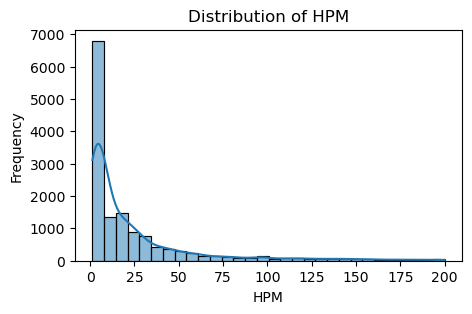

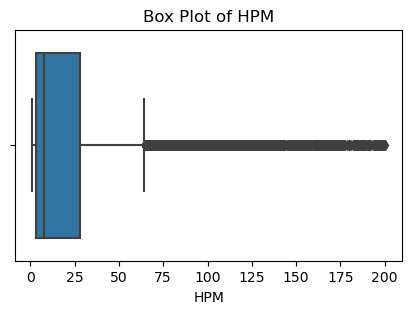

In [114]:
#remove unclassified and high HPM values
marti_refine = marti_all_data[(marti_all_data['NCBI Rank'] != 'unclassified') &
                               (marti_all_data['HPM'] < 200) & #Because otherwise the plots are too skewed
                               (marti_all_data['HPM'] > 0.1)]


# Plotting the histogram
plt.figure(figsize=(5, 3))
sns.histplot(marti_refine['HPM'], bins=30, kde=True)
plt.title('Distribution of HPM')
plt.xlabel('HPM')
plt.ylabel('Frequency')
plt.show()

# Plotting the box plot
plt.figure(figsize=(5, 3))
sns.boxplot(x=marti_refine['HPM'])
plt.title('Box Plot of HPM')
plt.xlabel('HPM')
plt.show()

In [116]:
pathogen_genera = ["Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", "Ustilago", "Magnaporthe",
                    "Claviceps", "Pyrenophora", "Parastagonospora", "Phaeosphaeria"]

pathogen_data = marti_all_data[
    marti_all_data["genus"].isin(pathogen_genera) &
    (marti_all_data['HPM'] > 5)
    ]

pathogen_data['genus'].value_counts()

genus
Pyrenophora         47
Fusarium            41
Ustilago            25
Zymoseptoria        24
Parastagonospora    23
Puccinia             7
Blumeria             2
Phaeosphaeria        1
Name: count, dtype: int64

Plotting the pathogenic genera relative abundance in each sample. Will need to remove the time fromm y axis in post processing

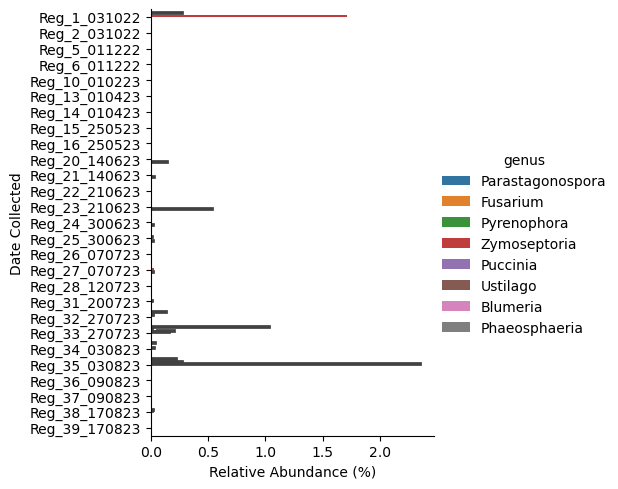

In [97]:

g = sns.catplot(data=pathogen_data,
                    y='Sample',
                    x='rel_abundance',
                    kind='bar',
                    hue='genus',
                    )

g.set_axis_labels("Relative Abundance (%)", "Date Collected")


Now with pathogen database reads

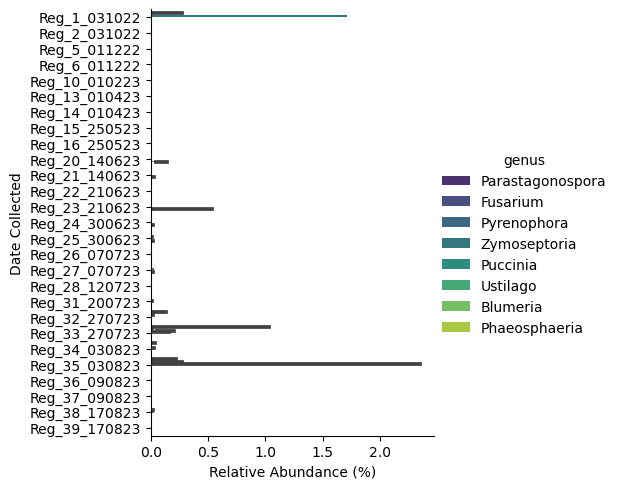

In [100]:
g = sns.catplot(data=pathogen_data,
                    y='Sample',
                    x='rel_abundance',
                    kind='bar',
                    hue='genus',
                    palette= 'viridis',
                    )

g.set_axis_labels("Relative Abundance (%)", "Date Collected")

In [16]:
# g = sns.catplot(data=pathogen_data,
#                     y='Date collected',
#                     x='count',
#                     kind='bar',
#                     hue='genus',
#                     palette= 'viridis',
#                     col='genus',
#                     col_wrap=3,
#                     sharex=False,
#                     )

# g.set_axis_labels("Read Count", "Date Collected")

Retrieving the taxaIDs of the pathogens that are present in my dataset so I can look for the read IDs

In [27]:
pathgoen_ids = pathogen_data[['taxid', 'species']].drop_duplicates()

pathgoen_id_list = [(row['taxid'], row['species']) for _, row in pathgoen_ids.iterrows()]

pathgoen_id_list

[(5128, 'Fusarium sambucinum'),
 (120017, 'Ustilago hordei'),
 (1047171, 'Zymoseptoria tritici'),
 (27350, 'Puccinia striiformis'),
 (34373, 'Blumeria graminis'),
 (5127, 'Fusarium fujikuroi'),
 (5297, 'Puccinia graminis'),
 (5270, 'Ustilago maydis'),
 (232082, 'Fusarium virguliforme'),
 (246455, 'Fusarium foetens'),
 (5507, 'Fusarium oxysporum'),
 (5516, 'Fusarium culmorum'),
 (5518, 'Fusarium graminearum'),
 (948311, 'Fusarium proliferatum'),
 (75915, 'Fusarium miscanthi'),
 (101028, 'Fusarium pseudograminearum'),
 (1803897, 'Fusarium agapanthi'),
 (169388, 'Fusarium solani'),
 (282267, 'Fusarium asiaticum'),
 (48490, 'Fusarium circinatum'),
 (5514, 'Fusarium sporotrichioides'),
 (117187, 'Fusarium verticillioides'),
 (331382, 'Puccinia horiana')]

23